## Landcover Classification Analysis

In [1]:
#import comet_ml
#from comet_ml import Experiment
import rasterio
#import keras
import random
# from keras import backend as K
# from keras.callbacks import ModelCheckpoint
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten, Reshape, Bidirectional
# from keras.layers import Conv2D, MaxPooling2D, MaxPooling3D, ConvLSTM2D, TimeDistributed, UpSampling2D, Concatenate, LSTM, concatenate
# from keras.layers import Activation, BatchNormalization
# from keras.optimizers import SGD, Adadelta, Adam
# from keras import Input
# from keras import Model
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import sys
#from sklearn.utils import class_weight
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels
import numpy as np

from rasterio.windows import Window
from pyproj import Proj, transform
from tqdm import tqdm
from shapely.geometry import Polygon, Point
import geopandas as gpd

#### Bring in classification rasters

In [152]:
rcnn_2011 = rasterio.open('rcnn_2011_clip.tif')
rcnn_2000 = rasterio.open('rcnn_2000_clip.tif')
dem = rasterio.open('noaa_slr_dem_clip.tif')

In [153]:
rcnn_2000.shape, rcnn_2011.shape, dem.shape

((8706, 6905), (8706, 6905), (8706, 6905))

In [210]:
array_2011 = rcnn_2011.read(1)
array_2000 = rcnn_2000.read(1)
array_dem = dem.read(1)

In [195]:
np.unique(array_2000), np.unique(array_2011)

(array([-128,   -1,    0,    1,    2,    3,    4,    5], dtype=int8),
 array([-128,   -1,    0,    1,    2,    3,    4,    5], dtype=int8))

In [211]:
# mask out arcgis based bad pixels
mask = (array_2011 != -128) & (array_2000 != -128)
# mask out bad pixels in either of the datasets
mask = (mask == 1) & (array_2011 != -1) & (array_2000 != -1)
# mask out everything except good pixels and developed
#mask = (mask == 1) & (array_2000 == 1)

# mask out water pixels from 2000
#mask = (mask == 1) & (array_2000 != 0) & (array_2011 != 0)

# mask out everything above 2m 
mask = (mask== 1) & (array_dem < 0.3) & (array_dem > -.5)

In [212]:
array_2000[mask != 1] = -1

In [213]:
array_2011[mask != 1] = -1

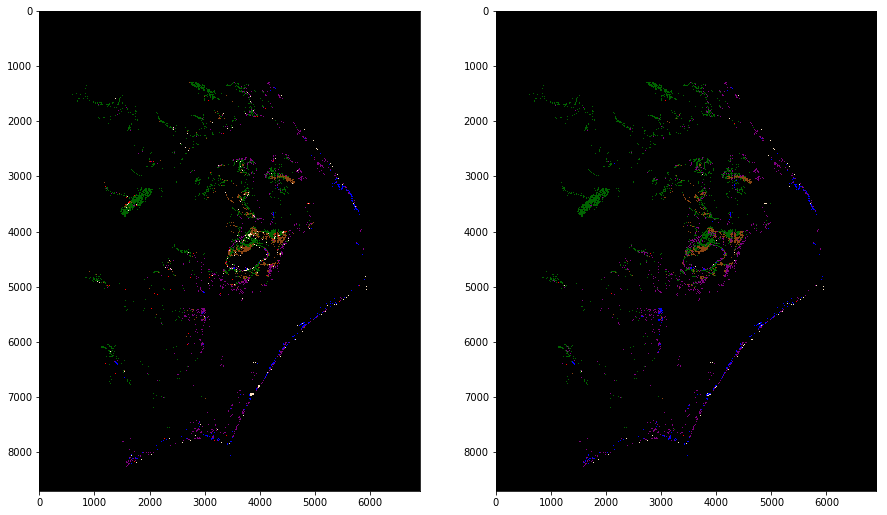

In [214]:
from matplotlib import colors

# Build a listed colormap.
c_map = colors.ListedColormap(['black', 'blue', 'red', 'darkgreen', 'saddlebrown', 'bisque', 'purple'])
bounds = [-1, 0, 1, 2, 3,4,5,6]
norm = colors.BoundaryNorm(bounds, c_map.N)

fig, axs = plt.subplots(1,2, figsize=(15,18))

# Plot the image with a color bar
axs[0].imshow(array_2000, cmap=c_map, norm=norm)
axs[1].imshow(array_2011, cmap=c_map, norm=norm)

In [215]:
np.count_nonzero(mask)

1188417

In [201]:
np.unique(array_2000[mask == 1], return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int8),
 array([  9903,   9533, 214691,  87732,  25439, 111951]))

In [202]:
np.unique(array_2011[mask == 1], return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int8),
 array([ 12419,   1309, 231408,  68104,   7532, 138477]))

In [203]:
def plot_stacked_bar(data, series_labels, category_labels=None, 
                     show_values=False, value_format="{}", y_label=None, 
                     colors=None, grid=True, reverse=False):
    """Plots a stacked bar chart with the data and labels provided.

    Keyword arguments:
    data            -- 2-dimensional numpy array or nested list
                       containing data for each series in rows
    series_labels   -- list of series labels (these appear in
                       the legend)
    category_labels -- list of category labels (these appear
                       on the x-axis)
    show_values     -- If True then numeric value labels will 
                       be shown on each bar
    value_format    -- Format string for numeric value labels
                       (default is "{}")
    y_label         -- Label for y-axis (str)
    colors          -- List of color labels
    grid            -- If True display grid
    reverse         -- If True reverse the order that the
                       series are displayed (left-to-right
                       or right-to-left)
    """

    ny = len(data[0])
    ind = list(range(ny))

    axes = []
    cum_size = np.zeros(ny)

    data = np.array(data)

    if reverse:
        data = np.flip(data, axis=1)
        category_labels = reversed(category_labels)

    for i, row_data in enumerate(data):
        color = colors[i] if colors is not None else None
        axes.append(plt.bar(ind, row_data, bottom=cum_size, 
                            label=series_labels[i], color=color))
        cum_size += row_data

    if category_labels:
        plt.xticks(ind, category_labels)

    if y_label:
        plt.ylabel(y_label)

    plt.legend()

    if grid:
        plt.grid()

    if show_values:
        for axis in axes:
            for bar in axis:
                w, h = bar.get_width(), bar.get_height()
                plt.text(bar.get_x() + w/2, bar.get_y() + h/2, 
                         value_format.format(h), ha="center", 
                         va="center")

In [204]:
np.unique(array_2000[mask == 1], return_counts=True)[1]

array([  9903,   9533, 214691,  87732,  25439, 111951])

In [205]:
list(zip(list(np.unique(array_2000[mask == 1], return_counts=True)[1]),
    list(np.unique(array_2011[mask == 1], return_counts=True)[1])))

[(9903, 12419),
 (9533, 1309),
 (214691, 231408),
 (87732, 68104),
 (25439, 7532),
 (111951, 138477)]

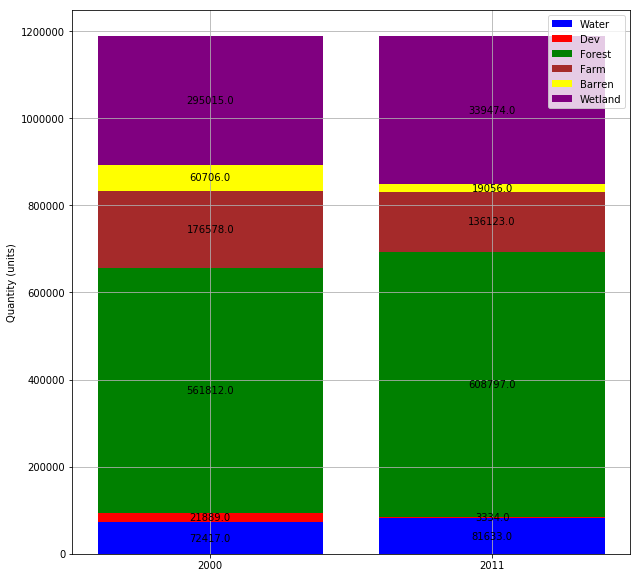

In [216]:
plt.figure(figsize=(10, 10))

series_labels = ['Water', 'Dev', 'Forest', 'Farm', 'Barren', 'Wetland']

data = list(zip(list(np.unique(array_2000[mask == 1], return_counts=True)[1]),
    list(np.unique(array_2011[mask == 1], return_counts=True)[1])))

category_labels = ['2000', '2011']

plot_stacked_bar(
    data, 
    series_labels, 
    category_labels=category_labels, 
    show_values=True, 
    value_format="{:.1f}",
    colors=['blue', 'red', 'green', 'brown', 'yellow', 'purple'],
    y_label="Quantity (units)"
)

#plt.savefig('bar.png')
plt.show()

In [217]:
# where it was farm in 2000 what did it become
wetland_mask = (mask== 1) & (array_2000 == 5)
farm_mask = (mask== 1) & (array_2000 == 3)
forest_mask = (mask== 1) & (array_2000 == 2)
water_mask = (mask== 1) & (array_2000 == 0)
barren_mask = (mask== 1) & (array_2000 == 4)
developed_mask = (mask== 1) & (array_2000 == 1)

In [218]:
transitions = zip(np.unique(array_2011[water_mask == 1], return_counts=True)[1], 
                  np.unique(array_2011[developed_mask == 1], return_counts=True)[1],
                  np.unique(array_2011[forest_mask == 1], return_counts=True)[1],
                  np.unique(array_2011[farm_mask == 1], return_counts=True)[1],
                  np.unique(array_2011[barren_mask == 1], return_counts=True)[1],
                  np.unique(array_2011[wetland_mask == 1], return_counts=True)[1])

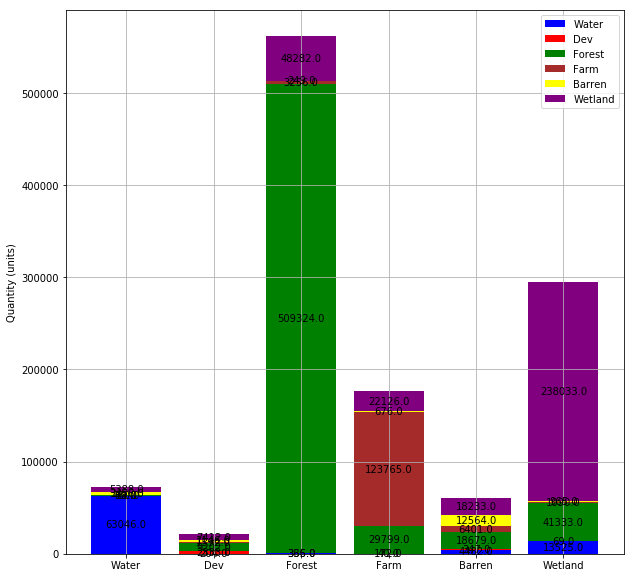

In [219]:
plt.figure(figsize=(10, 10))

series_labels = ['Water', 'Dev', 'Forest', 'Farm', 'Barren', 'Wetland']

data = list(transitions)

category_labels = ['Water', 'Dev', 'Forest', 'Farm', 'Barren', 'Wetland']

plot_stacked_bar(
    data, 
    series_labels, 
    category_labels=category_labels, 
    show_values=True, 
    value_format="{:.1f}",
    colors=['blue', 'red', 'green', 'brown', 'yellow', 'purple'],
    y_label="Quantity (units)"
)

#plt.savefig('forest_transition.png')
plt.show()

In [ ]:
could compliment this fig with a figure pulled from GEE of NDVI every month and showing trends of changes in NDVI across seasons and decades of Landsat 5

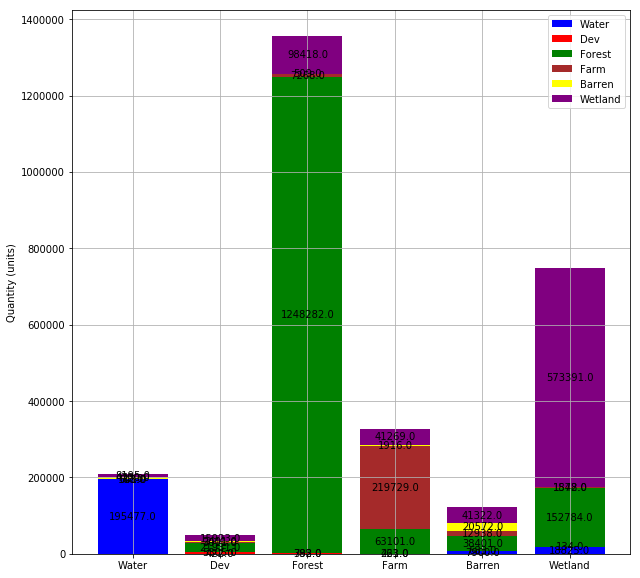

In [193]:
plt.figure(figsize=(10, 10))

series_labels = ['Water', 'Dev', 'Forest', 'Farm', 'Barren', 'Wetland']

data = list(transitions)

category_labels = ['Water', 'Dev', 'Forest', 'Farm', 'Barren', 'Wetland']

plot_stacked_bar(
    data, 
    series_labels, 
    category_labels=category_labels, 
    show_values=True, 
    value_format="{:.1f}",
    colors=['blue', 'red', 'green', 'brown', 'yellow', 'purple'],
    y_label="Quantity (units)"
)

#plt.savefig('forest_transition.png')
plt.show()

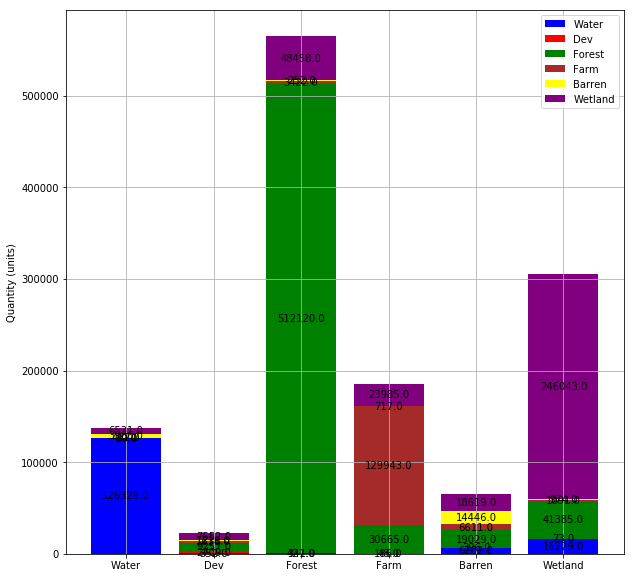

In [181]:
plt.figure(figsize=(10, 10))

series_labels = ['Water', 'Dev', 'Forest', 'Farm', 'Barren', 'Wetland']

data = list(transitions)

category_labels = ['Water', 'Dev', 'Forest', 'Farm', 'Barren', 'Wetland']

plot_stacked_bar(
    data, 
    series_labels, 
    category_labels=category_labels, 
    show_values=True, 
    value_format="{:.1f}",
    colors=['blue', 'red', 'green', 'brown', 'yellow', 'purple'],
    y_label="Quantity (units)"
)

#plt.savefig('forest_transition.png')
plt.show()

In [83]:
class_cts_2011 = np.unique(array_2011[mask == 1], return_counts=True)[1]
class_cts_2000 = np.unique(array_2000[mask == 1], return_counts=True)[1]

In [20]:
class_cts_2011, class_cts_2000

(array([ 297068,   94354, 3885233, 1230756,  154770, 1496366]),
 array([ 247702, 3468392, 1410619,  456543, 1575291]))

In [91]:
lc_type = ['water', 'developed', 'forest', 'agriculture', 'barren', 'wetland']
for lc, eleven, zero in (zip(lc_type, class_cts_028012_2011, class_cts_028012_2000)):
    print(lc, ': \t\t2000: ', zero, '\t2011: ', eleven, '\tdiff:', eleven-zero)

water : 		2000:  998089 	2011:  76 	diff: -998013


In [80]:
lc_type = ['water', 'developed', 'forest', 'agriculture', 'barren', 'wetland']
for lc, eleven, zero in (zip(lc_type, class_cts_028012_2011, class_cts_028012_2000)):
    print(lc, ': \t\t2000: ', zero, '\t2011: ', eleven, '\tdiff:', eleven-zero)

water : 		2000:  4736963 	2011:  4744741 	diff: 7778
developed : 		2000:  99793 	2011:  66594 	diff: -33199
forest : 		2000:  593829 	2011:  640813 	diff: 46984
agriculture : 		2000:  61431 	2011:  63150 	diff: 1719
barren : 		2000:  142074 	2011:  105072 	diff: -37002
wetland : 		2000:  336110 	2011:  349830 	diff: 13720


In [73]:
lc_type = ['water', 'developed', 'forest', 'agriculture', 'barren', 'wetland']
for lc, eleven, zero in (zip(lc_type, class_cts_028012_2011, class_cts_028012_2000)):
    print(lc, ': \t\t2000: ', zero, '\t2011: ', eleven, '\tdiff:', eleven-zero)

water : 		2000:  2267536 	2011:  2320636 	diff: 53100
developed : 		2000:  384488 	2011:  316637 	diff: -67851
forest : 		2000:  3164475 	2011:  3163434 	diff: -1041
agriculture : 		2000:  998089 	2011:  990909 	diff: -7180
barren : 		2000:  307309 	2011:  219366 	diff: -87943
wetland : 		2000:  495994 	2011:  606909 	diff: 110915


In [56]:
(10-8)/8

0.25

In [52]:
list(zip((class_cts_028012_2011-class_cts_028012_2011)/class_cts_028012_2011, 
         (class_cts_028012_2000-class_cts_028012_2011)/class_cts_028012_2011))

[(0.0, 0.21428639104084488),
 (0.0, 0.0003290727734480947),
 (0.0, 0.007245872224391947),
 (0.0, 0.4008962191041456),
 (0.0, -0.18275392192239692)]

0.0 0.21428639104084488
0.0 0.0003290727734480947
0.0 0.007245872224391947
0.0 0.4008962191041456
0.0 -0.18275392192239692


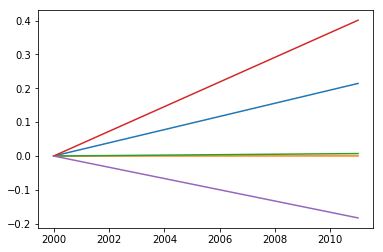

In [54]:
for x,y in list(zip((class_cts_028012_2011-class_cts_028012_2011)/class_cts_028012_2011, 
         (class_cts_028012_2000-class_cts_028012_2011)/class_cts_028012_2011)):
    print(x,y)
    plt.plot([2000, 2011],[x,y])

#### Visualize

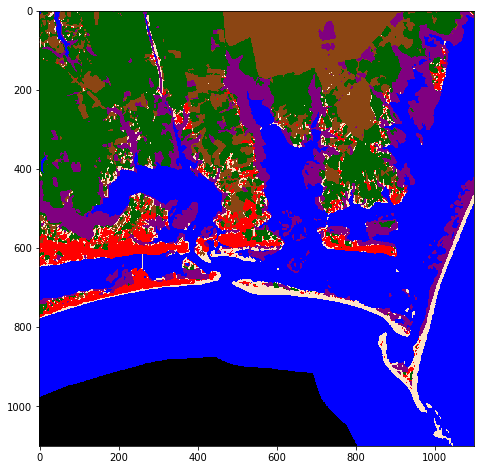

In [42]:
# 2011 RCNN with 9x9 trained also on val data vs 1999 RCNN with 9x9 trained also on val data

from matplotlib import colors

# Build a listed colormap.
c_map = colors.ListedColormap(['black', 'blue', 'red', 'darkgreen', 'saddlebrown', 'bisque', 'purple'])
bounds = [-1, 0, 1, 2, 3,4,5,6]
norm = colors.BoundaryNorm(bounds, c_map.N)

fig, axs = plt.subplots(figsize=(8,8))

# Plot the image with a color bar
axs.imshow(l8_mask_np2011.reshape(1100,1100), cmap=c_map, norm=norm)
#axs[1].set_title("Predicted Classes")

In [ ]:
view_landsat(landsat_datasets['028012'][0], ax=axs[0], dims=True)

#### Compare Across Years

In [230]:
counts1999 = np.unique(l8_mask_np1999val, return_counts=True)[1][1:]
counts2011 = np.unique(l8_mask_np2011val, return_counts=True)[1][1:]
#plt.plot()

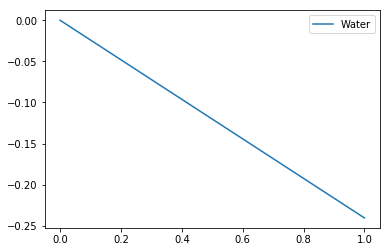

In [231]:
plt.plot(np.vstack((counts1999[1] - counts1999[1], (counts2011[1] - counts1999[1])/counts1999[1])))
plt.gca().legend(list(class_dict.values()))

In [227]:
list(class_dict.values())

['Water', 'Developed', 'Forest', 'Cultivated', 'Barren', 'Wetland']

In [219]:
np.unique(l8_mask_np1999val, return_counts=True)[1][1:]

array([503594,  89049, 215988, 120077,  33993, 104849])

In [226]:
np.unique(l8_mask_np2011val, return_counts=True)[1][1:]

array([512488,  67630, 232741, 113856,  32097, 108738])

In [222]:
# create a mask of 2010 wetland and then check to see what that was in 2000
np.unique(l8_mask_np1999val[l8_mask_np2011val == 1], return_counts=True)[1] 

array([  106, 59414,  1269,  3449,  2349,  1043])

In [ ]:
# create a mask of 2010 wetland and then check to see what that was in 2000
np.unique(l8_mask_np2011val[l8_mask_np1999val == 1], return_counts=True)

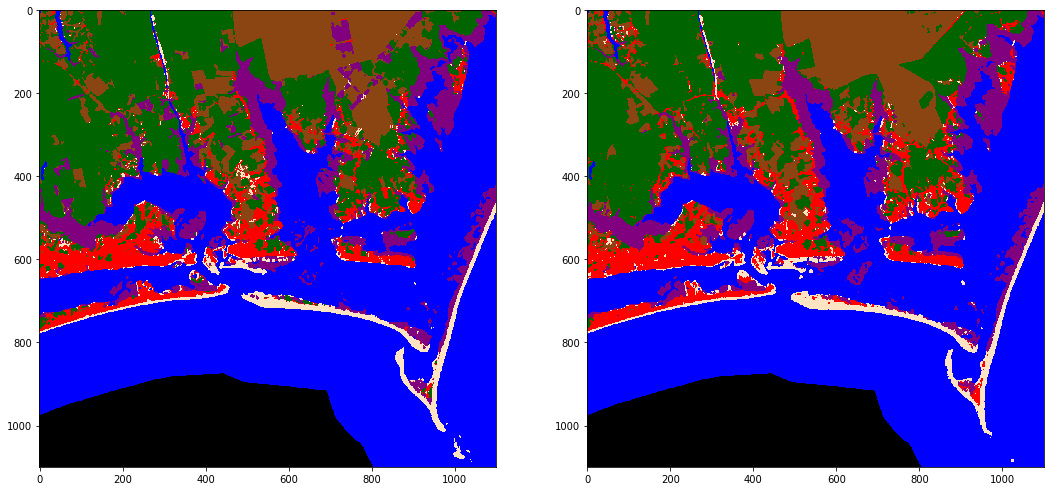

In [182]:
# 2011 RCNN with 9x9 trained also on val data vs 1999 RCNN with 9x9 trained also on val data

from matplotlib import colors

# Build a listed colormap.
c_map = colors.ListedColormap(['black', 'blue', 'red', 'darkgreen', 'saddlebrown', 'bisque', 'purple'])
bounds = [-1, 0, 1, 2, 3,4,5,6]
norm = colors.BoundaryNorm(bounds, c_map.N)

fig, axs = plt.subplots(1,2,figsize=(18,16))

# Plot the image with a color bar
axs[0].imshow(l8_mask_np2011val.reshape(1100,1100), cmap=c_map, norm=norm)
axs[1].imshow(l8_mask_np1999val.reshape(1100,1100), cmap=c_map, norm=norm)
#axs[1].set_title("Predicted Classes")

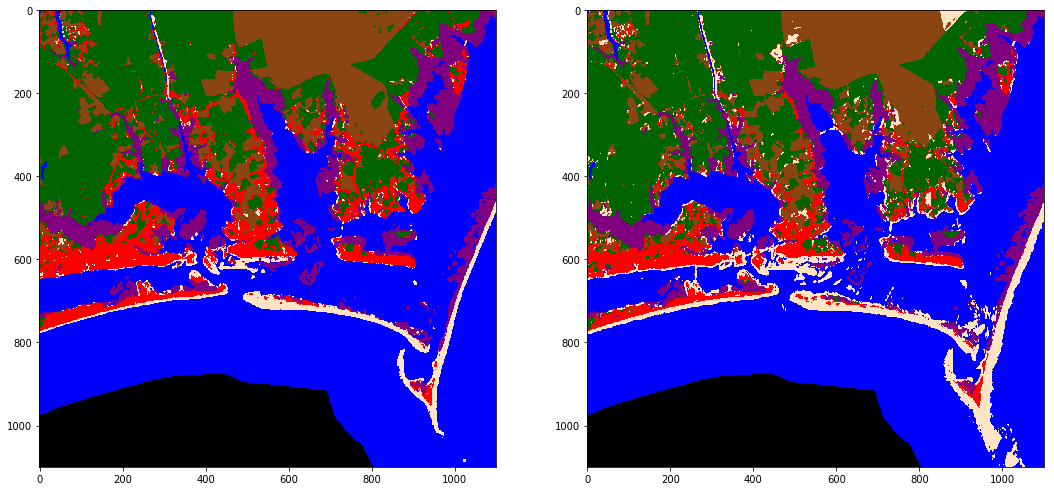

In [167]:
# 1999 RCNN with 9x9 tiles vs 1999 RCNN with 9x9 trained also on val data

from matplotlib import colors

# Build a listed colormap.
c_map = colors.ListedColormap(['black', 'blue', 'red', 'darkgreen', 'saddlebrown', 'bisque', 'purple'])
bounds = [-1, 0, 1, 2, 3,4,5,6]
norm = colors.BoundaryNorm(bounds, c_map.N)

fig, axs = plt.subplots(1,2,figsize=(18,16))

# Plot the image with a color bar
axs[0].imshow(l8_mask_np1999val.reshape(1100,1100), cmap=c_map, norm=norm)
axs[1].imshow(l8_mask_np.reshape(1100,1100), cmap=c_map, norm=norm)
#axs[1].set_title("Predicted Classes")

Text(0.5, 1.0, 'Predicted Classes 2000')

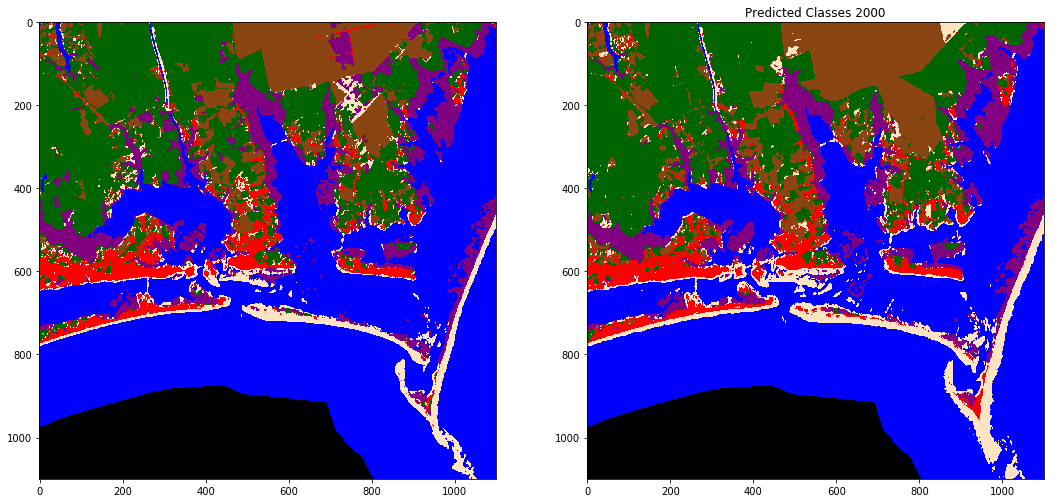

In [156]:
# RCNN with 9x9 tiles

from matplotlib import colors

# Build a listed colormap.
c_map = colors.ListedColormap(['black', 'blue', 'red', 'darkgreen', 'saddlebrown', 'bisque', 'purple'])
bounds = [-1, 0, 1, 2, 3,4,5,6]
norm = colors.BoundaryNorm(bounds, c_map.N)

fig, axs = plt.subplots(1,2,figsize=(18,16))

# Plot the image with a color bar
axs[0].imshow(l8_mask_np2011.reshape(1100,1100), cmap=c_map, norm=norm)
axs[1].set_title("Predicted Classes 2011")
axs[1].imshow(l8_mask_np.reshape(1100,1100), cmap=c_map, norm=norm)
axs[1].set_title("Predicted Classes 2000")

(3, 5000, 5000)
(5000, 5000, 3)


Text(0.5, 1.0, 'Predicted Classes')

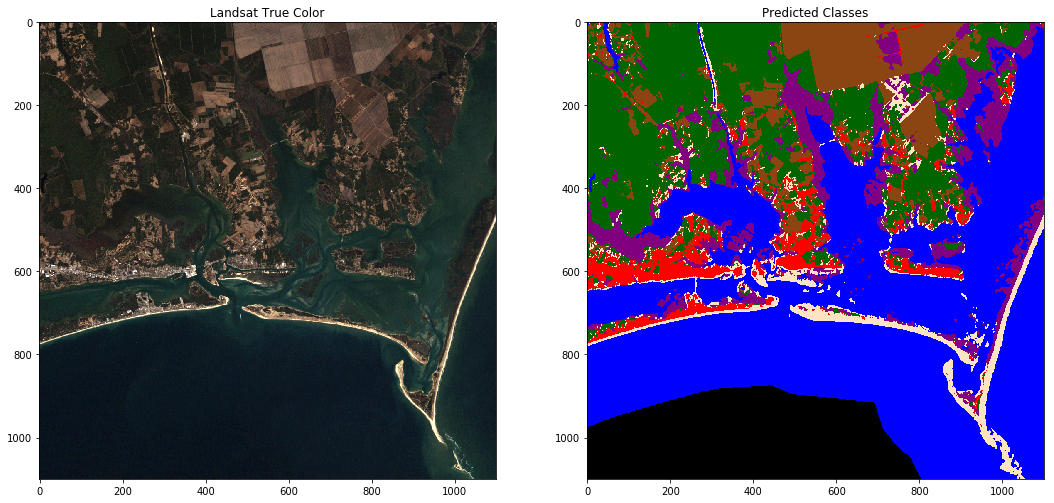

In [140]:
# RCNN with 9x9 tiles

from matplotlib import colors

# Build a listed colormap.
c_map = colors.ListedColormap(['black', 'blue', 'red', 'darkgreen', 'saddlebrown', 'bisque', 'purple'])
bounds = [-1, 0, 1, 2, 3,4,5,6]
norm = colors.BoundaryNorm(bounds, c_map.N)

fig, axs = plt.subplots(1,2,figsize=(18,16))

# Plot the image with a color bar
view_landsat(landsat_datasets['028012'][0], ax=axs[0], dims=True)
axs[1].imshow(l8_mask_np.reshape(1100,1100), cmap=c_map, norm=norm)
axs[1].set_title("Predicted Classes")

(3, 5000, 5000)
(5000, 5000, 3)


Text(0.5, 1.0, 'Predicted Classes')

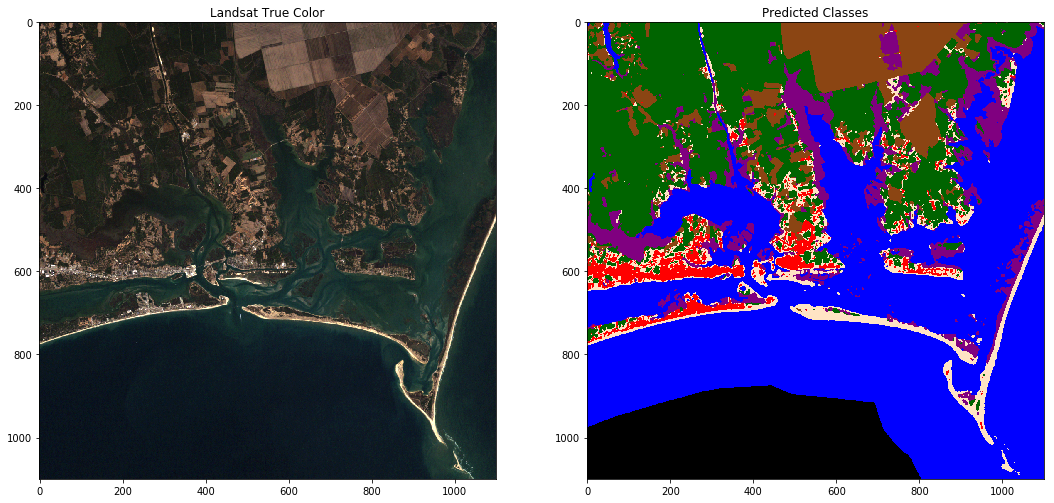

In [130]:
# CNN with 9x9 tiles

from matplotlib import colors

# Build a listed colormap.
c_map = colors.ListedColormap(['black', 'blue', 'red', 'darkgreen', 'saddlebrown', 'bisque', 'purple'])
bounds = [-1, 0, 1, 2, 3,4,5,6]
norm = colors.BoundaryNorm(bounds, c_map.N)

fig, axs = plt.subplots(1,2,figsize=(18,16))

# Plot the image with a color bar
view_landsat(landsat_datasets['028012'][0], ax=axs[0], dims=True)
axs[1].imshow(l8_mask_np.reshape(1100,1100), cmap=c_map, norm=norm)
axs[1].set_title("Predicted Classes")

(3, 5000, 5000)
(5000, 5000, 3)


Text(0.5, 1.0, 'Predicted Classes')

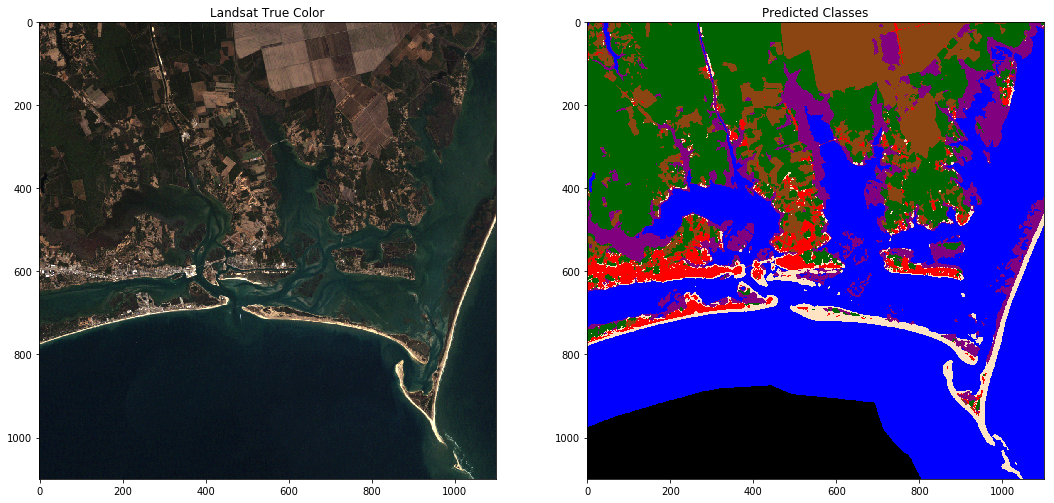

In [112]:
# RNN with single pixels

from matplotlib import colors

# Build a listed colormap.
c_map = colors.ListedColormap(['black', 'blue', 'red', 'darkgreen', 'saddlebrown', 'bisque', 'purple'])
bounds = [-1, 0, 1, 2, 3,4,5,6]
norm = colors.BoundaryNorm(bounds, c_map.N)

fig, axs = plt.subplots(1,2,figsize=(18,16))

# Plot the image with a color bar
view_landsat(landsat_datasets['028012'][0], ax=axs[0], dims=True)
axs[1].imshow(l8_mask_np.reshape(1100,1100), cmap=c_map, norm=norm)
axs[1].set_title("Predicted Classes")

(3, 5000, 5000)
(5000, 5000, 3)


Text(0.5, 1.0, 'Predicted Classes')

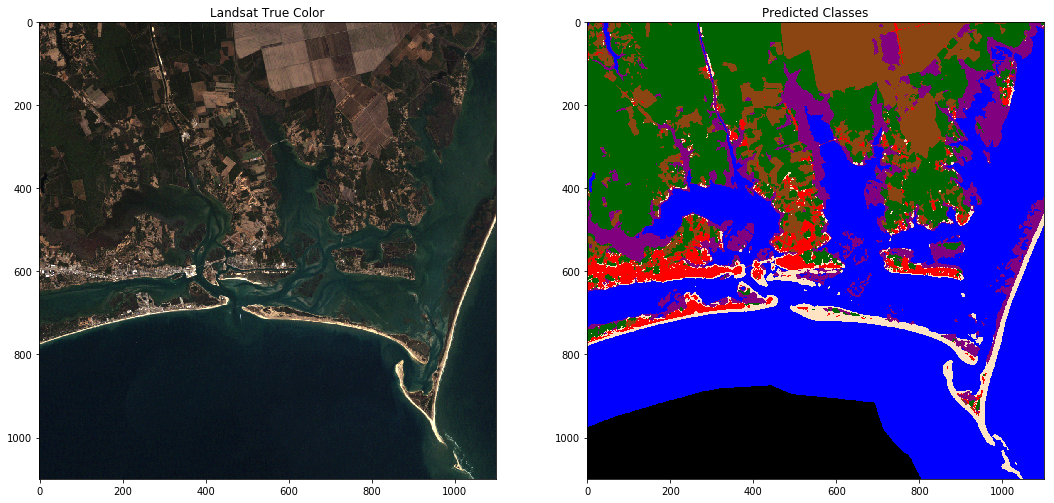

In [104]:
# Random Forest with 13x13 tiles

from matplotlib import colors

# Build a listed colormap.
c_map = colors.ListedColormap(['black', 'blue', 'red', 'darkgreen', 'saddlebrown', 'bisque', 'purple'])
bounds = [-1, 0, 1, 2, 3,4,5,6]
norm = colors.BoundaryNorm(bounds, c_map.N)

fig, axs = plt.subplots(1,2,figsize=(18,16))

# Plot the image with a color bar
view_landsat(landsat_datasets['028012'][0], ax=axs[0], dims=True)
axs[1].imshow(l8_mask_np.reshape(1100,1100), cmap=c_map, norm=norm)
axs[1].set_title("Predicted Classes")

(3, 5000, 5000)
(5000, 5000, 3)


Text(0.5, 1.0, 'Predicted Classes')

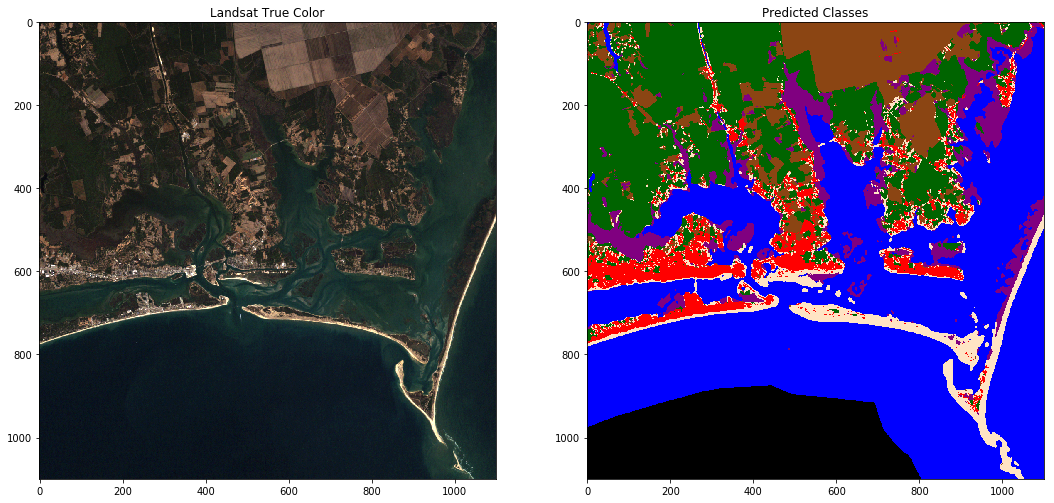

In [59]:
# RCNN LSTM with 13x13 tiles
from matplotlib import colors

# Build a listed colormap.
c_map = colors.ListedColormap(['black', 'blue', 'red', 'darkgreen', 'saddlebrown', 'bisque', 'purple'])
bounds = [-1, 0, 1, 2, 3,4,5,6]
norm = colors.BoundaryNorm(bounds, c_map.N)

fig, axs = plt.subplots(1,2,figsize=(18,16))

# Plot the image with a color bar
view_landsat(landsat_datasets['028012'][0], ax=axs[0], dims=True)
axs[1].imshow(l8_mask_np.reshape(1100,1100), cmap=c_map, norm=norm)
axs[1].set_title("Predicted Classes")

In [184]:
np.save('img3000.npy', img3000)
np.load('img3000.npy').shape

(3000, 3000)

In [44]:

from rasterio.plot import reshape_as_raster, reshape_as_image

def normalize_rgb(tile):
    tile = tile[[2, 1, 0],:,:].astype(np.float64)
    print(tile.shape)
    max_val = 2500
    min_val = 0
    # Enforce maximum and minimum values
    tile[tile[:, :, :] > max_val] = max_val
    tile[tile[:, :, :] < min_val] = min_val
    for b in range(tile.shape[0]):
        tile[b, :, :] = tile[b, :, :] * 1 / (max_val - min_val)
    tile_reshaped = reshape_as_image(tile)
    return tile_reshaped

def view_landsat(landsat, ax=None, dims=None):
    #image_dataset = landsat
    full_img = landsat.read()
    #print(full_img.shape)
    colors_reshaped = normalize_rgb(full_img)
    print(colors_reshaped.shape)
    if dims:
        colors_reshaped = colors_reshaped[800:1900, 3200:4300,:]
    if ax==None:
        fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(colors_reshaped)
    ax.set_title("Landsat True Color")